# Análisis abierto de actas Bolivia, elecciones Octubre 2019

Hola, soy Pablo! Un científico de datos profesional quien inspirado en las conversaciones sobre el análisis de fraude; particularmente por lo que dicen (en contraposición) [Edgar Villegas](https://www.paginasiete.bo/nacional/2019/10/25/los-12-tipos-de-irregularidades-que-encontraron-en-el-computo-del-tse-235494.html) y [Lykke Andersen](http://www.la-epoca.com.bo/2019/10/26/lykke-e-andersen-investigadora-y-miembro-de-la-academia-boliviana-de-ciencias-economicas-no-existe-evidencia-de-un-fraude-masivo/). Quiero contribuir en algo a a buscar objetividad fuera de rumores e ideología en lo que respecta a  la situación actual de nuestro país. Es decir, quiero perseguir la verdad sea la cual fuese. Pueden contactarme por pablitoactas@gmail.com, todos los comentarios son apreciados. No pretendo que este sea un trabajo completo, ni que abarque todas las posibilidades de fraude. Pretendo comenzar una discusión y motivar a que todos empiecen a trabajar con los datos disponibles.

Este análisis es un trabajo que queda abierto a crítica y discusión de todo quien quiera contribuir. Deseo gente que colabore sin importar su afiliación política. En este análisis no busco un resultado en particular sino más bien algo que nos ayude a pensar objetivamente acerca de los sucesos pasados. Reconozco por tal las flaquezas y limitaciones de la metodología y datos usados, y se invita al resto de profesionales a comentar y modificar. El código no es "elegante" a propósito, es para que la mayor cantidad de gente posible pueda seguir que está pasando aunque no sea versada en Python. Este Notebook queda abierto ahora y siempre. Espero que a todos los que contribuyamos nos guste la verdad:

![SegmentLocal](esverdad.gif "verdad")

## Dependencias

In [1]:
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile
import numpy as np 
import matplotlib as plt
from scipy import stats

## Datos

Los datos fueron bajados de la página del [Organo Electoral Plurinacional](https://www.oep.org.bo/), en categoría "Mundo" en Octubre 26 del 2019. Se bajaron dos tipos de archivos en formato .xlsx:

* Actas del conteo rápido TREP

* Actas de cómputo final

Abajo, las importamos como dataframes en pandas para fácil manejo

In [2]:
#Datos del TREP

dftrep=pd.read_excel("acta.2019.10.25.21.07.40.xlsx")

#Datos del conteo final

dfcomputo=pd.read_excel("acta.2019.10.25.21.09.30.xlsx")


## Análisis exploratorio

Para comenzar el análisis nos fijaremos en cosas muy simples:

* La distribución de votos válidos
* La distribución de inscritos
* Cualquier posible error de conteo en votos totales (por ejemplo, filas donde el número de inscritos sean menores al número de votos totales)

Sólo voy a fijarme en las elecciones de presidente y vicepresidente.  Por ende filtraremos filas que no sigan eso.


In [3]:
#TREP
prestrep=dftrep.copy()
prestrep=prestrep[prestrep['Elección']=='Presidente y Vicepresidente']

#Cómputo Final
prescomputo=dfcomputo.copy()
prescomputo=prescomputo[prescomputo['Elección']=='Presidente y Vicepresidente']

Veamos la distribución de votos válidos e inscritos para las actas en TREP sólo para la elección presidencial. Primero votos válidos

In [4]:
prestrep['Votos Válidos'].to_frame().describe()

,Votos Válidos
count,33044.000000
mean,178.186781
std,40.734557
min,0.000000
25%,177.000000
50%,192.000000
75%,201.000000
max,255.000000


Tenemos 33044 filas, con una media de 178.186781 una mediana de 192 y una desviación estándar de 40.734, un mínimo de cero y un máximo de 255 veamos un histograma con 10 barras (ancho de cada categoría 25.5):

In [5]:
prestrep['Votos Válidos'].to_frame().hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E7066BABE0>]],
      dtype=object)

Veamos las actas del cómputo final

In [6]:
prescomputo['Votos Válidos'].to_frame().describe()

,Votos Válidos
count,34555.000000
mean,177.623441
std,41.255785
min,0.000000
25%,176.000000
50%,192.000000
75%,201.000000
max,255.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E707AB47B8>]],
      dtype=object)

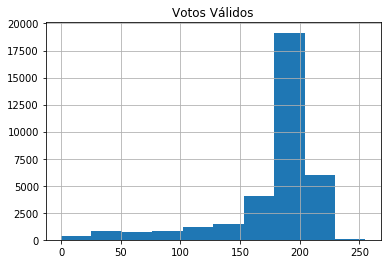

In [7]:
prescomputo['Votos Válidos'].to_frame().hist()

Vemos poca diferencia entre las distribuciones de votos válidos  en ambas instancias. La media de votos validos en TREP es ligeramente más alta que en el cómputo final (178.18 cs 177.62) y la desviación estándar del trep es un poco más baja. Sin embargo, los datos del cómputo final también cuentan con más filas de información( 33044 en TREP, 34555 en cómputo final).

Esto por el momento indica que ambos son similares.


Veamos la distribución de inscritos, primero TREP luego cómputo oficial:

In [8]:
prestrep['Inscritos'].to_frame().describe()

,Inscritos
count,33044.000000
mean,212.334584
std,43.330404
min,7.000000
25%,220.000000
50%,226.000000
75%,231.000000
max,258.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E707B0B978>]],
      dtype=object)

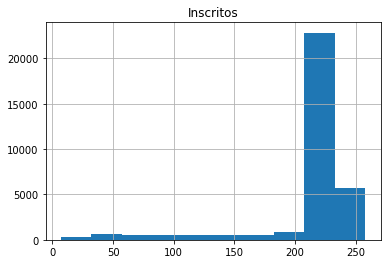

In [10]:
prestrep['Inscritos'].to_frame().hist()

In [9]:
prescomputo['Inscritos'].to_frame().describe()

,Inscritos
count,34555.000000
mean,211.702040
std,44.203336
min,5.000000
25%,220.000000
50%,226.000000
75%,231.000000
max,258.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E707A9D588>]],
      dtype=object)

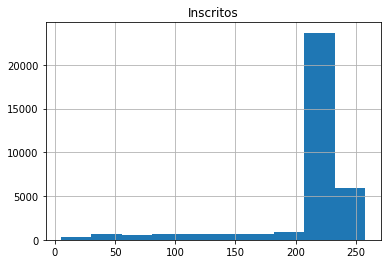

In [11]:
prescomputo['Inscritos'].to_frame().hist()

Tal como en el caso de las distribuciones de votos válidos, no existen mayores diferencias entre las distribuciones de inscritos al contrastar TREP y cómputo final.

Veamos si existen discrepancias entre el número total de votos (válidos + nulos +blancos) y el número de inscritos. Primero hagamos la columna que genera el número total de votos:

In [12]:
#TREP
prestrep["Votos totales"]=prestrep["Votos Válidos"]+ prestrep['Blancos']+prestrep['Nulos']
#diferencias entre inscritos y votos totales
prestrep["Diferencia"]=prestrep["Inscritos"]-prestrep["Votos totales"]

#Final
prescomputo['Votos totales']=prescomputo["Votos Válidos"]+ prescomputo['Blancos']+prescomputo['Nulos']
#diferencias entre inscritos y votos totales
prescomputo["Diferencia"]=prescomputo["Inscritos"]-prescomputo["Votos totales"]


Las irregularidades en ambos tipos de actas se miden de la siguiente manera si la columna diferencia tiene valores negativos en se caso se registran más votos que inscritos, veamos las distribuciones. Primero TREP:

In [13]:
prestrep['Diferencia'].to_frame().describe()

,Diferencia
count,33044.000000
mean,24.809981
std,19.021041
min,-49.000000
25%,16.000000
50%,22.000000
75%,28.000000
max,239.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E7058270F0>]],
      dtype=object)

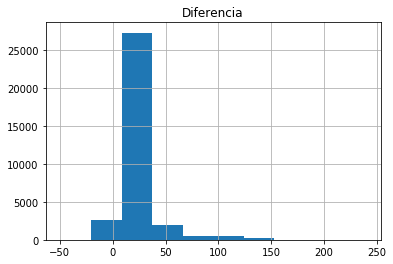

In [14]:
prestrep['Diferencia'].to_frame().hist()

Esto indica que hay ciertas filas que registran una mayor cantidad de votantes que de inscritos. Pero cuántas son? Y que proporción del TREP forman? Veamos:

In [15]:
#Número de filas y mesas con más votos que inscritos

prestrep[prestrep["Diferencia"]<0].shape[0]

64

In [18]:
#Proporción de mesas con más votos que inscritos dentro del total

prestrep[prestrep["Diferencia"]<0].shape[0]/(prestrep.shape[0]*1.)

0.001936811524028568

Es un 0.19% de las mesas con irregularidad. Podemos generar los códigos, país y municipio de esas mesas al igual que el tamaño de la diferencia:

In [17]:
prestrep[prestrep["Diferencia"]<0][['País', 'Municipio','Código Mesa', 'Diferencia']]

,País,Municipio,Código Mesa,Diferencia
4005,Bolivia,Sucre,100320127940022714,-1
6723,Bolivia,Nuestra Señora de La Paz,100320207290160313,-10
8415,Bolivia,Ayo Ayo,100320205740283605,-2
8437,Bolivia,Calamarca,100320205760283901,-2
10403,Bolivia,El Alto,100320208200120515,-1
11144,Bolivia,Nuestra Señora de La Paz,100320207290300207,-5
11270,Bolivia,Palca,100320207720000106,-2
13211,Bolivia,Nuestra Señora de La Paz,100320207292503628,-13
16016,Bolivia,Achacachi,100320201040244703,-6
17198,Bolivia,Huatajata,100320201060240106,-2


Realizamos el mismo análisis para el cómputo final:

In [16]:
prescomputo['Diferencia'].to_frame().describe()

,Diferencia
count,34555.000000
mean,24.735697
std,18.635949
min,-43.000000
25%,16.000000
50%,22.000000
75%,29.000000
max,239.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E70017D748>]],
      dtype=object)

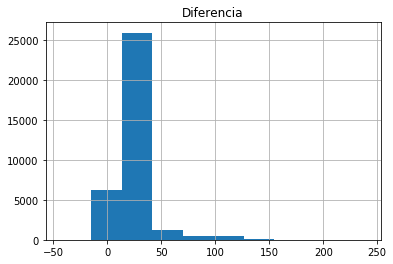

In [21]:
prescomputo['Diferencia'].to_frame().hist()

In [20]:
#Número de filas y mesas con más votos que inscritos

prescomputo[prescomputo["Diferencia"]<0].shape[0]

42

In [19]:
#Proporción de mesas con más votos que inscritos dentro del total

prescomputo[prescomputo["Diferencia"]<0].shape[0]/(prescomputo.shape[0]*1.)

0.001215453624656345

Es un 0.12% de las mesas con irregularidad. Podemos generar los códigos, país y municipio de esas mesas al igual que el tamaño de la diferencia:

In [23]:
prescomputo[prescomputo["Diferencia"]<0][['País', 'Municipio','Código Mesa', 'Diferencia']]

,País,Municipio,Código Mesa,Diferencia
4159,Bolivia,Sucre,100320127940022714,-1
11419,Bolivia,Nuestra Señora de La Paz,100320207290300207,-5
13539,Bolivia,Nuestra Señora de La Paz,100320207292503628,-13
16415,Bolivia,Achacachi,100320201040244703,-6
18011,Bolivia,Sorata,100320202540252102,-9
21360,Bolivia,San Pedro de Curahuara,100320206722581301,-1
21600,Bolivia,Sapahaqui,100320203850278407,-43
21648,Bolivia,Yaco,100320203920279102,-1
21953,Bolivia,Colquiri,100320204332534401,-12
21975,Bolivia,Colquiri,100320204340262603,-4


Por el momento se ve poca irregularidad dentro de las actas. A pesar de que las diferencias en algunas mesas llaman la atención, la frecuencia de irregularidades es insuficiente para hablar de fallos en general. Con esto, podemos confirmar que tenemos datos que son generalmente buenos para analizar.

# Diferencias entre TREP y cómputo final, elecciones presidenciales Comunidad Ciudadana (CC) y MAS-IPSP

Parte de los comentarios en prensa del ingeniero Villegas y la doctora Andersen están basados en cómo se diferencian las actas del TREP y el cómputo final en relación a los votos. Como vemos en la sección exploratoria, la desviación estándar por mesa es relativamente alta (~40) por lo cual, utilizaremos una medida normalizada de votos para los partidos que podrían haberse confrontado en una segunda vuelta electoral (MAS y CC). Los votos normalizados serán simplemente la proporción de votos de cada partido en términos de votos emitidos por mesa:

$$PropPartido=\frac{\text{Número de votos recibidos}}{\text{Número de votos totales en mesa}}$$

Adicionalmente, sólo utilizaré las mesas presentes en ambas hojas de excel. 

Me parece que el simplemente ver si las proporciones son iguales en ambas hojas de excel, esla medida que se entiende utilizada del análisis de Villegas y Andersen. Preferiría hacer algo más robusto para ver si hay diferencia estadísticamente significante. Para tal, voy a utilizar un test de [Anderson- Darling para k muestras](https://amstat.tandfonline.com/doi/abs/10.1080/01621459.1987.10478517#.XbST4OhKiUk) en las distribuciones de proporciones de votos entre TREP y cómputo oficial para ambos partidos. 

El test de Anderson-Darling para k tiene como hipótesis nula que dos muestras provienen de la misma distribución. Es decir, si esta es rechazada, tenemos suficiente evidencia (dependiendo de cuán tolerantes seamos al error de tipo I) para decir que dos muestras no vienen de la misma distribución. El módulo scipy en python tiene la implementación del test que utilizaré en este análisis.

Para evitar divisiones entre cero, eliminaré todas las mesas anuladas (donde el total de votos válidos es cero). 



In [22]:
#eliminando divisiones entre cero
#TREP
TREP=prestrep.copy()
TREP=TREP[TREP['Votos totales']!=0]

#Computo final

COMP=prescomputo.copy()
COMP=COMP[COMP['Votos totales']!=0]


#Creando las proporciones de votos
#TREP

TREP['propMAS'], TREP['propCC']=TREP['MAS - IPSP']/(TREP['Votos totales']*1.), TREP['CC']/(TREP['Votos totales']*1.)

#Computo final

COMP['propMAS'], COMP['propCC']=COMP['MAS - IPSP']/(COMP['Votos totales']*1.), COMP['CC']/(COMP['Votos totales']*1.)


Para continuar analizando posibles errores de cómputo, buscaré mesas donde la proporción de votos obtenida por los partidos MAS y CC son mayores a los votos totales, y luego calcularé su proporción. Primero TREP

In [24]:
#Mesas donde proporcion de votos del MAS es mayor a votos totales
TREP[TREP['propMAS']>1][['Código Mesa','País', 'Municipio', 'MAS - IPSP', 'CC','Votos totales','propMAS', 'propCC']]

,Código Mesa,País,Municipio,MAS - IPSP,CC,Votos totales,propMAS,propCC
124,110111141452515002,Argentina,San Carlos,167,3,113,1.477876,0.026549
5925,100320127940051906,Bolivia,Sucre,38,142,15,2.533333,9.466667
10425,100320208200120608,Bolivia,El Alto,140,23,117,1.196581,0.196581
10445,100320208200120618,Bolivia,El Alto,36,6,1,36.000000,6.000000
11435,100320227430000205,Bolivia,Achocalla,161,13,154,1.045455,0.084416
14426,100320208200100306,Bolivia,El Alto,69,101,7,9.857143,14.428571
19106,100320205110226301,Bolivia,Pucarani,95,14,32,2.968750,0.437500
20020,100320208200210104,Bolivia,El Alto,126,35,117,1.076923,0.299145
22722,100320308210021903,Bolivia,Cochabamba,60,117,7,8.571429,16.714286
23934,100320308210023901,Bolivia,Cochabamba,101,74,32,3.156250,2.312500


In [28]:
#Proporción del total
TREP[TREP['propMAS']>1].shape[0]/TREP.shape[0]


0.0007265241872010656

In [25]:
#Mesas donde proporcion de votos de CC es mayor a votos totales

TREP[TREP['propCC']>1][['Código Mesa','País', 'Municipio', 'MAS - IPSP', 'CC','Votos totales','propMAS', 'propCC']]

,Código Mesa,País,Municipio,MAS - IPSP,CC,Votos totales,propMAS,propCC
5885,100320127940020406,Bolivia,Sucre,1,31,1,1.000000,31.000000
5925,100320127940051906,Bolivia,Sucre,38,142,15,2.533333,9.466667
9234,100320207290040101,Bolivia,Nuestra Señora de La Paz,33,148,124,0.266129,1.193548
10445,100320208200120618,Bolivia,El Alto,36,6,1,36.000000,6.000000
14426,100320208200100306,Bolivia,El Alto,69,101,7,9.857143,14.428571
22722,100320308210021903,Bolivia,Cochabamba,60,117,7,8.571429,16.714286
23934,100320308210023901,Bolivia,Cochabamba,101,74,32,3.156250,2.312500
24229,100320308210013607,Bolivia,Cochabamba,40,148,4,10.000000,37.000000
27502,100320309360901533,Bolivia,Quillacollo,78,109,106,0.735849,1.028302
28956,100320310050103816,Bolivia,Villa Tunari,197,6,4,49.250000,1.500000


In [27]:
#Proporción del total
TREP[TREP['propCC']>1].shape[0]/TREP.shape[0]


0.0004843494581340437

Vemos que si bien existen irregularidades, la proporción de mesas es extremadamente pequeña. Realizamos el mismo análisis para las mesas del cómputo final

In [26]:
#Mesas donde proporcion de votos del MAS es mayor a votos totales

COMP[COMP['propMAS']>1][['Código Mesa','País', 'Municipio', 'MAS - IPSP', 'CC','Votos totales','propMAS', 'propCC']]

,Código Mesa,País,Municipio,MAS - IPSP,CC,Votos totales,propMAS,propCC
31,110111041402518801,Argentina,La Plata,97,7,5,19.400000,1.400000
124,110111141452515002,Argentina,San Carlos,167,3,113,1.477876,0.026549
10679,100320208200120608,Bolivia,El Alto,140,23,117,1.196581,0.196581
15653,100320201730301401,Bolivia,Calacoto,85,0,2,42.500000,0.000000
20070,100320205560281803,Bolivia,Sicasica,33,0,30,1.100000,0.000000
23464,100320308210021903,Bolivia,Cochabamba,60,117,7,8.571429,16.714286
30014,100320310050103816,Bolivia,Villa Tunari,197,6,4,49.250000,1.500000
30022,100320310050103820,Bolivia,Villa Tunari,189,4,6,31.500000,0.666667
32172,100320310252502805,Bolivia,Totora,68,4,12,5.666667,0.333333
32526,100320339580000102,Bolivia,Vinto,182,18,160,1.137500,0.112500


In [30]:
#Proporción del total
COMP[COMP['propMAS']>1].shape[0]/COMP.shape[0]

0.0006657211496714811

In [31]:
COMP[COMP['propCC']>1][['Código Mesa','País', 'Municipio', 'MAS - IPSP', 'CC','Votos totales','propMAS', 'propCC']]

,Código Mesa,País,Municipio,MAS - IPSP,CC,Votos totales,propMAS,propCC
31,110111041402518801,Argentina,La Plata,97,7,5,19.400000,1.400000
6057,100320127940020406,Bolivia,Sucre,1,31,1,1.000000,31.000000
23464,100320308210021903,Bolivia,Cochabamba,60,117,7,8.571429,16.714286
30014,100320310050103816,Bolivia,Villa Tunari,197,6,4,49.250000,1.500000
40526,100320514940001606,Bolivia,Potosí,38,110,15,2.533333,7.333333
45534,100320722342547017,Bolivia,Santa Cruz de La Sierra,25,152,4,6.250000,38.000000
48983,100320722340600028,Bolivia,Santa Cruz de La Sierra,19,149,3,6.333333,49.666667
54003,100320722340000934,Bolivia,Santa Cruz de La Sierra,71,99,7,10.142857,14.142857
55477,100320722341003005,Bolivia,Santa Cruz de La Sierra,105,34,15,7.000000,2.266667
59359,100320733211103705,Bolivia,Cotoca,123,44,7,17.571429,6.285714


In [32]:
#Proporción del total
COMP[COMP['propCC']>1].shape[0]/COMP.shape[0]

0.0004341659671770529

Dado a que la proporción de irregularidades es tan baja, es posible que estos sean simplemente errores. Podemos continuar el análisis de distribuciones con estos datos sin mayores contratiempos. También repetiré el análisis de distribuciones sin estas mesas para asegurar que este es un análisis robusto. Ahora nos toca unir las mesas que aparecen en ambas hojas de excel para hacer nuestras comparaciones. Del TREP, sólo necesitamos las columnas de proporción de votos del MAS y de CC, las otras columnas son innecesarias.

In [33]:
dfjunto=pd.merge(COMP, TREP[['Código Mesa', 'propMAS', 'propCC']], how='inner', on='Código Mesa')

Las columnas que tienen de sufijo *_x* provienen de el computo final (propMAS_x, propCC_x) y las que tienen sufijo *_y* (propMAS_y, propCC_y) provienen del TREP. Utilizaremos un test de Anderson-Darling para ver si las distribuciones de estas proporciones de votos.


Corriendo el test de Anderson-Darling para los votos del MAS:

In [34]:
stats.anderson_ksamp([dfjunto['propMAS_x'], dfjunto['propMAS_y']])

C:\Users\Pablo\Anaconda2\envs\py356\lib\site-packages\ipykernel_launcher.py:1: UserWarning: p-value capped: true value larger than 0.25
  """Entry point for launching an IPython kernel.


Anderson_ksampResult(statistic=-1.187740592911257, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.25)

Corriendo el test de Anderson-Darling para los votos de CC:

In [35]:
stats.anderson_ksamp([dfjunto['propCC_x'], dfjunto['propCC_y']])

C:\Users\Pablo\Anaconda2\envs\py356\lib\site-packages\ipykernel_launcher.py:1: UserWarning: p-value capped: true value larger than 0.25
  """Entry point for launching an IPython kernel.


Anderson_ksampResult(statistic=-1.2824817297469964, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.25)

*significance_level* en ambos casos se refiere al p-value del test. SciPy imprime un p-value máximo de 0.25. Lo que indican estos resultados es que no podemos rechazar la hipótesis de que en el caso de la proporción de votos del MAS o del CC provengan de diferentes poblaciones entre TREP o conteo final. Lo cual indica que no hay cambios estructurales grandes entre TREP o conteo final utilizando las hojas de dato del principio de este documento. Esto confirma el análisis de Lykke Andersen, utilizando específicamente los datos de la OEP como estuvieron en la página cuando los bajé y están en este repositorio para analizarse. 
 
Es posible que tengamos que hacer cálculos más robustos, y hay al menos la oportunidad de un análisis mas comparando datos del TREP y los conteos. Sería interesante examinar si:

1. Existen diferencias estructurales entre los datos del 25 de octubre y versiones anteriores

2. Si las conclusiones del test de Anderson-Darling se mantienen con versiones anteriores de los datos

Le he estado dando vueltas a esto todo el día y estoy cansado. Si tienen sugerencias o comentarios, por favor escríbanme. Estoy seguro de que podemos ver esto a mucha profundidad y responder preguntas interesantes. Hasta entonces, dejo este documento aquí.

Un abrazo de oso para todos los que han seguido mi primer día de ponerme a investigar estos datos.


# 28 de Octubre del 2019

Me tomé ayer para trabajar en otras cosas y para pensar en cómo incluir datos de hojas de TREP pasadas. No pude encontrar acceso a hojas de datos viejas de fuentes oficiales. Por ende debo poner esta advertencia:

*Advertencia* : El análisis que viene abajo utiliza los datos que Edgar Villegas y su grupo [bajaron](https://bit.ly/2WkrIdM) y se encuentran distribuídas por redes sociales. No puedo garantizar que estos datos sean de hecho los mismos que el OEP publicó. Sin embargo, no puedo encontrar otros datos que utilizar en este momento. 

Lo que me toca hacer hoy:

1. Escoger 2 hojas de TREP y 2 de cómputo oficial: una de antes del corte de información del 20 de octubre, una después
2. Hacer el análisis del 26 (lo haré con funciones dado que ya he explicado lo suficiente
3. Comparar las 3 hojas (las dos de Villegas y la que bajé el Sábado) y ver si son estructuralmente diferentes.

Este análisis por el momento sólo busca evidenciar si existen diferencias estructurales significativas. Todos los comentarios son bien recibidos. 

Si quieren que haga algún otro tipo de análisis, por favor contáctenme a pablitoactas@gmail.com

NO ESTOY CASADO CON RESULTADOS

Todo lo que utilice queda abierto en el repositorio de GitHub donde hago esto.

Para empezar, armaré funciones para hacer las evaluaciones exploratorias del viernes mucho más rápidas

In [36]:
def diferencia(datos):
    
    #Sólo presidenciales
    
    pres=datos.copy()
    pres=pres[pres['Elección']=='Presidente y Vicepresidente']
    
    #Diferencia entre Votos totales e inscritos

    pres["Votos totales"]=pres["Votos Válidos"]+ pres['Blancos']+pres['Nulos']
    
    pres["Diferencia"]=pres["Inscritos"]-pres["Votos totales"]
    
    #Vemos los datos que tienen más votos totales que inscritos
    pres2=pres.copy()
    
    pres2=pres2[pres2["Diferencia"]<0][['País', 'Municipio','Código Mesa', 'Diferencia']]
    
    #eliminando divisiones entre cero

    TOT=pres.copy()
    TOT=TOT[TOT['Votos totales']!=0]

    #Creando las proporciones de votos


    TOT['propMAS'], TOT['propCC']=TOT['MAS - IPSP']/(TOT['Votos totales']*1.), TOT['CC']/(TOT['Votos totales']*1.)

    #Mesas donde proporcion de votos del MAS es mayor a votos totales
    TOTMAS=TOT[TOT['propMAS']>1][['Código Mesa','País', 'Municipio', 'MAS - IPSP', 'CC','Votos totales','propMAS', 'propCC']]
    
    #Mesas donde proporcion de votos de CC es mayor a votos totales
    TOTCC=TOT[TOT['propCC']>1][['Código Mesa','País', 'Municipio', 'MAS - IPSP', 'CC','Votos totales','propMAS', 'propCC']]

    
    dflist=[pres, pres2, TOT, TOTMAS, TOTCC]
    
    return(dflist)
    

## Importando los datos del grupo de Edgar Villegas

In [37]:
#Datos del TREP
#Pre-corte
dftreppre=pd.read_excel("acta.2019.10.20.19.40.57(TREP).xlsx")

#Post- corte
dftreppos=pd.read_excel("acta.2019.10.21.19.14.53(TREP).xlsx")


#Datos del conteo final

#Pre-corte
dfcomputopre=pd.read_excel("acta.2019.10.20.22.29.52(COMP).xlsx")

#Post-corte
dfcomputopos=pd.read_excel("acta.2019.10.21.20.28.51(COMP).xlsx")


# Continuando análisis 29 de Octubre

Paren rotativas, voy a cambiar lo que estaba haciendo ayer porque después de ver otros análisis, sobre todo el espectacular trabajo de [Rómulo Chumacero](http://rchumace.econ.uchile.cl/papers/cmh.pdf?fbclid=IwAR1p5t5qFh_6vodh9jc4XSym0iX1vUOfNLCpQQka4WHQscxr0OTSi7IbLoM) me di cuenta que me había saltado algo muy importante en mi análisis del 26. No había visto si las actas que eran parte del cómputo final y no del TREP eran diferentes en las distribuciones de votos del MAS y del CC que las que sí.

Este soy yo:

![SegmentLocal](burrito.gif "burrito")

Las razones para querer evaluar este grupo de actas importan, porque son una cantidad importante (ya lo pongo abajo), y porque siguen perteneciendo a la misma población de votos, por ende no debiesen mostrar una estructura distinta.

Y además, puedo seguir utilizando sólo los datos oficiales del OEP que bajé el Sábado. No tengo que depender de los datos del grupo de Edgar Villegas, lo cual me tranquiliza un poco porque siguen siendo datos conseguidos sin intermediarios. 

Primero hagamos un dataframe con las actas que pertenecen al cómputo oficial pero no al TREP :


In [81]:
dfsintrep=pd.merge(COMP, TREP, how='outer', on='Código Mesa', indicator=True)
dfsintrep=dfsintrep[dfsintrep['_merge']=='left_only'].dropna(axis=1)

Veamos cuántas actas son:

In [102]:
dfsintrep.shape[0]

1515

Veamos cuántas actas teía el cómputo oficial:

In [103]:
COMP.shape[0]

34549

In [ ]:
Y saquemos la proporción

In [84]:
dfsintrep.shape[0]/COMP.shape[0]

0.04385076268488234

Aproximadamente un 4.39% de las actas del cómputo oficial no forman parte del TREP. Les muestro las primeras 20:

In [104]:
dfsintrep.head(20)

,País_x,Número departamento_x,Departamento_x,Provincia_x,Número municipio_x,Municipio_x,Localidad_x,Recinto_x,Número Mesa_x,Código Mesa,...,PAN-BOL_x,Votos Válidos_x,Blancos_x,Nulos_x,Estado acta,Votos totales_x,Diferencia_x,propMAS_x,propCC_x,_merge
213,Argentina,22,Salta,Orán,1,San Ramón de la Nueva Orán,San Ramón de la Nueva Orán,Escuela De Comercio Julio Cortez Nº 5091,1668,110112237652509001,...,0,200,4,2,Computada,206,33,0.902913,0.033981,left_only
214,Argentina,22,Salta,Orán,1,San Ramón de la Nueva Orán,San Ramón de la Nueva Orán,Escuela De Comercio Julio Cortez Nº 5091,1669,110112237652509002,...,3,217,4,1,Computada,222,17,0.855856,0.040541,left_only
215,Argentina,22,Salta,Orán,1,San Ramón de la Nueva Orán,San Ramón de la Nueva Orán,Escuela De Comercio Julio Cortez Nº 5091,1670,110112237652509003,...,0,215,3,3,Computada,221,18,0.882353,0.045249,left_only
216,Argentina,22,Salta,Orán,1,San Ramón de la Nueva Orán,San Ramón de la Nueva Orán,Escuela De Comercio Julio Cortez Nº 5091,1671,110112237652509004,...,0,224,4,1,Computada,229,9,0.899563,0.039301,left_only
217,Argentina,22,Salta,Orán,1,San Ramón de la Nueva Orán,San Ramón de la Nueva Orán,Escuela De Comercio Julio Cortez Nº 5091,1672,110112237652509005,...,0,92,7,0,Computada,99,29,0.878788,0.020202,left_only
242,Argentina,89,Neuquén,Confluencia,1,Centenario,Centenario,Centro de Formación Profesional N° 29 Darrieux...,1697,110118943792609101,...,0,191,2,19,Computada,212,27,0.830189,0.018868,left_only
243,Argentina,89,Neuquén,Confluencia,1,Centenario,Centenario,Centro de Formación Profesional N° 29 Darrieux...,1698,110118943792609102,...,0,169,1,31,Computada,201,38,0.796020,0.014925,left_only
244,Argentina,89,Neuquén,Confluencia,1,Centenario,Centenario,Centro de Formación Profesional N° 29 Darrieux...,1699,110118943792609103,...,1,157,0,38,Computada,195,45,0.743590,0.025641,left_only
245,Argentina,89,Neuquén,Confluencia,1,Centenario,Centenario,Centro de Formación Profesional N° 29 Darrieux...,1700,110118943792609104,...,1,54,0,10,Computada,64,7,0.703125,0.031250,left_only
269,Bolivia,1,Chuquisaca,Oropeza,1,Sucre,Surima,Escuela Fray Gabriel Maria Landini,10009,100320112070005503,...,3,155,15,7,Computada,177,32,0.638418,0.107345,left_only


Ahora voy a correr tests de Anderson Darling comparando estas actas a las que están tanto en el TREP como en el cómputo final sobre las distribuciones de votos del MAS y de CC.

Primero lo haré con la distribución de proporciones de votos del MAS en el cómputo final por mesa de actas que estaban tanto en el TREP como en el cómputo final con las actas que estaban en el cómputo final pero no en el TREP (sí, a mí también ya se me trabó la lengua):

In [87]:
stats.anderson_ksamp([dfjunto['propMAS_x'], dfsintrep['propMAS_x']])

C:\Users\Pablo\Anaconda2\envs\py356\lib\site-packages\ipykernel_launcher.py:1: UserWarning: p-value floored: true value smaller than 0.001
  """Entry point for launching an IPython kernel.


Anderson_ksampResult(statistic=38.66653538538379, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.001)

El p-value del test está escrito como *significance_level* , en este caso es el valor mínimo que Python deja imprimir. Esto implica que el test rechaza la hipótesis que estas proporciones salen de la misma distribución a varios niveles de significancia. Es decir que hay evidencia que vienen de **poblaciones con distribuciones distintas**.

Hago el mismo test sobre la distribución de proporciones de votos del MAS en el TREP por mesa de actas que estaban tanto en el TREP comparándose con las actas que estaban en el cómputo final pero no en el TREP 

In [89]:
stats.anderson_ksamp([dfjunto['propMAS_y'], dfsintrep['propMAS_x']])

C:\Users\Pablo\Anaconda2\envs\py356\lib\site-packages\ipykernel_launcher.py:1: UserWarning: p-value floored: true value smaller than 0.001
  """Entry point for launching an IPython kernel.


Anderson_ksampResult(statistic=39.25172385777677, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.001)

Como ven otra vez tenemos evidencia de que vienen de **poblaciones con distribuciones distintas**

Hago los mismos dos tests que acabo de hacer con las proporciones de datos de Comunidad Ciudadana:

In [90]:
stats.anderson_ksamp([dfjunto['propCC_x'], dfsintrep['propCC_x']])

C:\Users\Pablo\Anaconda2\envs\py356\lib\site-packages\ipykernel_launcher.py:1: UserWarning: p-value floored: true value smaller than 0.001
  """Entry point for launching an IPython kernel.


Anderson_ksampResult(statistic=90.66365724530637, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.001)

In [92]:
stats.anderson_ksamp([dfjunto['propCC_y'], dfsintrep['propCC_x']])

C:\Users\Pablo\Anaconda2\envs\py356\lib\site-packages\ipykernel_launcher.py:1: UserWarning: p-value floored: true value smaller than 0.001
  """Entry point for launching an IPython kernel.


Anderson_ksampResult(statistic=89.91708736191669, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.001)

Las conclusiones son iguales, provienen de poblaciones con distribuciones distintas.

Esta es una irregularidad interesante ya que hablamos de un porcentaje alto de actas pertenecientes al cómputo final que no se asemejan a la distribución de este. Podemos hacer un par de tests más. Qué pasa si incluimos **todas** las actas del cómputo final y vemos como se comparan con las actas que pertenecieron al cómputo final pero no al TREP? 

Veamos repitiendo el ejercicio para el MAS y CC:

In [108]:
stats.anderson_ksamp([COMP['propMAS'], dfsintrep['propMAS_x']])

C:\Users\Pablo\Anaconda2\envs\py356\lib\site-packages\ipykernel_launcher.py:1: UserWarning: p-value floored: true value smaller than 0.001
  """Entry point for launching an IPython kernel.


Anderson_ksampResult(statistic=35.064097497076396, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.001)

In [109]:
stats.anderson_ksamp([COMP['propCC'], dfsintrep['propCC_x']])

C:\Users\Pablo\Anaconda2\envs\py356\lib\site-packages\ipykernel_launcher.py:1: UserWarning: p-value floored: true value smaller than 0.001
  """Entry point for launching an IPython kernel.


Anderson_ksampResult(statistic=82.55281883466729, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.001)

Vemos que también pertenecen a **poblaciones de distribuciones distintas**

La inclusión de las actas que estaban excluidas del TREP no igualan las distribuciones. 


## Observaciones desde el sábado 26 de Octubre hasta ahora

*No he hecho nada con lo del Lunes 28 de Octubre aún.*

Ahora sumarizemos que hemos visto desde el sábado:

* Con la definición específica de "Votos totales" que tengo descrita en el 26 de Octubre, encontramos pocas actas con errores de suma irregulares

* Con esa misma definición, al sacar la proporción de votos del MAS y de CC, encontramos pocas mesas con proporciones imposibles.

* Usando tales proporciones, vemos que utilizando actas que están conjuntamente en el cómputo final y el TREP, las proporciones de votos del MAS y CC tienen las mismas distribuciones (acorde al test de Anderson Darling) entre ambos dataframes

* Usando las actas excluidas del TREP pero que si están en el cómputo final, encontramos que estas actas son una proporción importante y que tienen **distintas distribuciones** con las actas tanto en el TREP como las del cómputo final que están en la intersección de actas del TREP y cómputo final para el MAS y CC

* Usando las actas excluidas del TREP pero que si están en el cómputo final, encontramos que estas actas son una proporción importante y que tienen **distintas distribuciones** con todas las actas del cómputo final

Algunas cosas que debo mirar aún gracias a comentarios y otros trabajos:

* Mi definición de "Votos totales"  utiliza la suma de las columnas de "Votos válidos", "Nulos" y "Blancos." Debiese tal vez sacar mis proporciones utilizando las sumas de los votos por partido, nulos y blancos para ver como sale el ejercicio. Esto viene a que es posible que "Votos válidos" podrían estar no bien definidos. 

* Aún me queda explorar si las estructuras de las tablas cambian con diferentes ediciones de ellas de manera significativa.

* **Importante** Las diferencias entre las distribuciones de las actas excluidas del TREP y otras en porcentajes de votos pueden darse porque las actas vienen de sin TREP provienen de áreas en su mayoría rurales. Lo importante es ver si esto es consistente una vez que se agrupan por región geográfica. 

Seguro que ustedes tienen más ideas. Pero ya es casi media noche y me muero de ganas de dormir. Aviso como siempre que **no estoy casado con ningún resultado**, lo que quiero ver es simplemente que me dicen los datos. Sé que este no es el análisis más complicado del planeta, pero es para lo que me da el tanque entre otras obligaciones. Por favor compartan este análisis que es un poco un blog para seguir recibiendo ideas y críticas. Me pueden escribir a pablitoactas@gmail.com 

Por ahora un abrazo de oso a todos los que le han dado un vistazo a este Notebook.


In [ ]:
COMP